In [81]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import silkscreen
from silkscreen.utils import get_reddening
from astropy.coordinates import SkyCoord
import corner
from astropy.visualization import make_lupton_rgb
device = 'cpu'
import paths

if 'snakemake' in globals():
    params = snakemake.params
    print (snakemake.params)
else:
    params = dict(name = 'ESO_294_10', seed = 42)
torch.manual_seed(seed=params['seed'])

truth_dict_all = {}
truth_dict_all['ESO_294_10'] = {'param':[2.,np.log10(1.64)+7,-1.7, None,None,None],'ref': 'Da Costa et al. (2010), Weisz et al. (2011)', 'param_unc':[0.1,0.22,0.1, None,None,None] }
truth_dict_all['ESO_410_05'] = {'param':[1.9,np.log10(2)+7.,-1.8, None,None,None],'ref': 'Da Costa et al. (2010), Weisz et al. (2011)', 'param_unc':[0.1,None,0.1, None,None,None] }
truth_dict_all['ESO_540_32'] = {'param':[3.54,np.log10(3.41)+7.,-1.7, None,None,None],'ref': 'Dalcanton et al. (2010), Jergen et al. (2001), Weisz et al. (2011)', 'param_unc':[0.077,None,0.2, None,None,None] }

truth_dict = truth_dict_all[params['name']]
gal_dir = f"{paths.data}/sculptor_dwarf/{params['name']}/"
obs_dir = gal_dir+'obs/'
post_dir = gal_dir+'post/'
post_version = 'V27_'

In [82]:

ra,dec = np.loadtxt(obs_dir + 'ra_dec_dw.txt')
try:
    red_vec = get_reddening(SkyCoord(ra,dec, unit = 'deg'), ['DECam_g','DECam_r', 'DECam_z'])
except FileNotFoundError:
    import dustmaps.sfd
    dustmaps.sfd.fetch()
    red_vec = get_reddening(SkyCoord(ra,dec, unit = 'deg'), ['DECam_g','DECam_r', 'DECam_z'])

psfs = np.load(obs_dir+'psfs.npy')
psfs = psfs[:,31-15:31+15,31-15:31+15]

ser_dict = torch.load(obs_dir + 'sersic_param_dict.pt')

obs_arr = torch.load(obs_dir+'cutout.pt').numpy()

iso_kwargs = dict(mag_limit=27, mag_limit_band='DECam_r')

obs = silkscreen.SilkScreenObservation(data = obs_arr, imager = 'DECam', filters = ['DECam_g','DECam_r', 'DECam_z'], sky_sb = [ 22.04, 20.91, 18.46],
exp_time = [87*2,67*2,100*2], pixel_scale = 0.262, zpt = 22.5, psf = psfs, distribution= 'sersic', distribution_kwargs=ser_dict, iso_kwargs=iso_kwargs,
extinction_reddening = red_vec)

simmer = silkscreen.simmer.DefaultDwarfFixedAgeSimmer(obs)
prior = silkscreen.priors.get_default_dwarf_fixed_age_prior([0.5,5.], [5.5,7.5], device = device)

/Users/timothymiller/micromamba/envs/pytorch/lib/python3.10/site-packages/sbi/utils/user_input_checks_utils.py:69: UserWarning: Prior is lacking mean attribute, estimating prior mean from samples.
  warnings.warn(
/Users/timothymiller/micromamba/envs/pytorch/lib/python3.10/site-packages/sbi/utils/user_input_checks_utils.py:80: UserWarning: Prior is lacking variance attribute, estimating prior variance from
                samples...
  warnings.warn(


In [83]:
rounds = [0,1,2]

post_list = []

for r in rounds:
    post = torch.load(f'{post_dir}{post_version}posterior_round_{r}.pt', map_location='cpu', )
    post_list.append(post.sample(sample_shape=(50_000,),x = post.default_x).numpy())
prior_samples = prior.sample( (50_000,) ).numpy()

Drawing 50000 posterior samples:   0%|          | 0/50000 [00:00<?, ?it/s]

Drawing 50000 posterior samples:   0%|          | 0/50000 [00:00<?, ?it/s]

Drawing 50000 posterior samples:   0%|          | 0/50000 [00:00<?, ?it/s]

In [84]:
#Simulate galaxies from samples of the posterior
inj_img = np.load(f'{obs_dir}for_inj.npy')
post_im_samps = []
for theta_post in post_list[-1][:8]:
    x,y = np.random.randint(1000,2000, size = 2)
    inj_cutout = inj_img[:,x:x+obs_arr.shape[1], y:y+obs_arr.shape[2]]
    gal_img = simmer.get_image_for_injec(x = theta_post)
    fake_obs = gal_img+inj_cutout
    post_im_samps.append(fake_obs)

Text(0.1, 0.4, 'Da Costa et al. (2010), Weisz et al. (2011)')

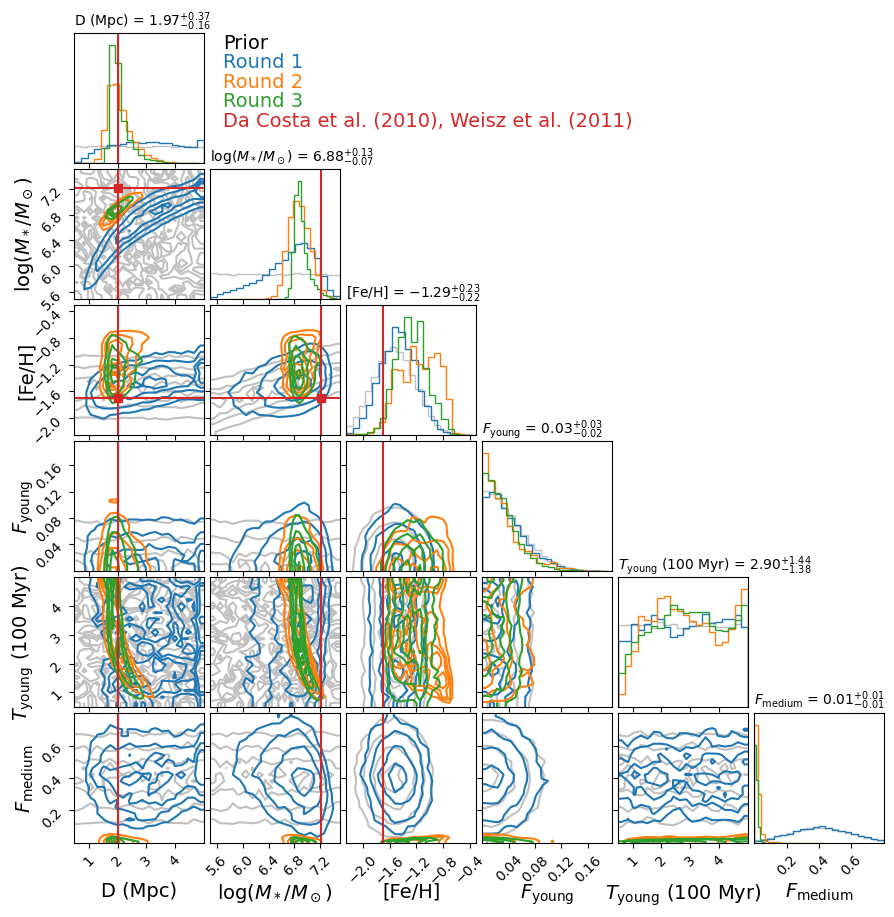

In [85]:
corner_fig = plt.figure(figsize=(9,9))

var_labels = ['D (Mpc)', r'log$(M_* / M_\odot)$', '[Fe/H]', r'$F_{\rm young}$',r'$T_{\rm young}$ (100 Myr)',r'$F_{\rm medium}$']
corner.corner(prior_samples, plot_density = False, plot_datapoints = False, color = 'silver', fig = corner_fig,labels= var_labels)

for r in rounds:
    if r == rounds[-1]:
        corner.corner(post_list[r], plot_density = False, plot_datapoints = False, color = f'C{r}', fig = corner_fig,truths=truth_dict['param'], truth_color='C3', show_titles= True, labels = var_labels,\
          label_kwargs = {'fontsize':14}, title_kwargs = {'fontsize':10, 'loc':'left'})
    else:
        corner.corner(post_list[r], plot_density = False, plot_datapoints = False, color = f'C{r}', fig = corner_fig)

ax_text = corner_fig.axes[1]
text_fs = 14
ax_text.text(0.1,1,'Prior', color = 'k', ha = 'left', va = 'top',fontsize = text_fs, transform= ax_text.transAxes)
ax_text.text(0.1,.85,'Round 1', color = 'C0', ha = 'left', va = 'top',fontsize = text_fs, transform= ax_text.transAxes)
ax_text.text(0.1,.7,'Round 2', color = 'C1', ha = 'left', va = 'top',fontsize = text_fs, transform= ax_text.transAxes)
ax_text.text(0.1,.55,'Round 3', color = 'C2', ha = 'left', va = 'top',fontsize = text_fs, transform= ax_text.transAxes)
ax_text.text(0.1,.4,truth_dict['ref'], color = 'C3', ha = 'left', va = 'top',fontsize = text_fs, transform= ax_text.transAxes)

plt.savefig(f"{paths.figures}/{params['name']}_post_corner.pdf")

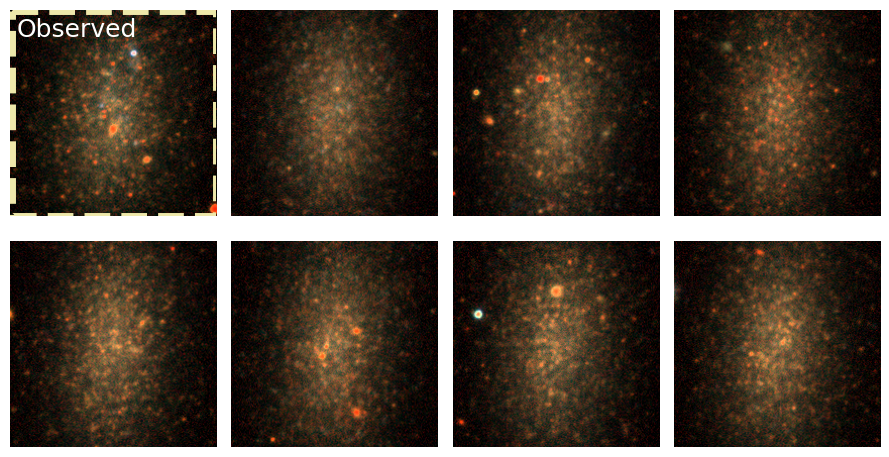

In [87]:
im_fig = plt.figure(figsize=(5,9))
#params['st'] = 0.2#0.06
#params['Q'] = 0.4#0.1
st = params['st']
Q = params['Q']
rgb_obs = make_lupton_rgb(obs_arr[2],obs_arr[1], obs_arr[0], stretch=st, Q = Q, minimum=0e-2)

axes = im_fig.subplots(4,2)

for j,ax in enumerate(axes.flatten() ):
    ax.axis('off')
    if j == 0:
        ax.imshow(rgb_obs)
    else:
        im_cur = post_im_samps[j-1]
        rgb_cur = make_lupton_rgb(im_cur[2],im_cur[1], im_cur[0], stretch=st, Q = Q, minimum=0e-2)
        ax.imshow(rgb_cur)
x_outline = [1,obs_arr.shape[1]-1, obs_arr.shape[1]-1, 1,1]
y_outline = [1,1,obs_arr.shape[1]-1, obs_arr.shape[1]-1,1]
axes[0][0].plot(x_outline,y_outline, '--', color = 'palegoldenrod', lw = 5,)
axes[0][0].text(0.03,0.96,'Observed', color = 'white', ha = 'left', va = 'top',fontsize = 18, transform= axes[0][0].transAxes)


im_fig.tight_layout()
plt.savefig(f"{paths.figures}/{params['name']}_ims_post.pdf")